In [1]:
!pip install gudhi
!pip install POT
!pip install eagerpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 11.2 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import random
import copy
import torchvision
import torch
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from torchvision import transforms as T
from keras.datasets import mnist
from torch import nn
from gudhi.wasserstein import wasserstein_distance
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
np.random.seed(12345)
random.seed(12345)
torch.manual_seed(12345)

In [4]:
# Вспомогательная функция для отрисовки изображений
def plot(img):
    plt.figure()
    plt.imshow(img.detach().numpy().reshape(28, 28), cmap='gray')

## Задание параметров

In [5]:
beta = 0.25
batch_size_value = 64
n_repeats = 3
n_epochs = 50
lr = 1e-3
noise = 'topological'
# noise = 'salt&pepper'
# noise = 'gaussian'

## Задаём модели

In [6]:
class Autoencoder(nn.Module):

    def __init__(self, d_input, d_hidden):
        super().__init__()
        self.autoencoder = nn.Sequential(
            MLP(d_input, d_hidden * 4, d_hidden),
            MLP(d_hidden, d_hidden * 4, d_input)
        )

    def forward(self, X):
        return self.autoencoder(X)


class MLP(nn.Module):

    def __init__(self, in_channels, h_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.GELU(),
            nn.Linear(h_channels, out_channels)
        )

    def forward(self, X):
        return self.mlp(X)

## Подготовка данных

In [7]:
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: torch.flatten(x))
])

In [8]:
# Загружаем датасет
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

11490434/11490434 [==============================] - 1s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


In [9]:
# Задаём вид шума
def add_noise(img, noise_type):
    if noise_type == 'topological':
        row, col = 28, 28
        coef = 0.2
        img = img.astype(np.float32)
        row, col = img.shape
        num_of_lines = int((row + col) * coef)
        for i in range(num_of_lines):
            x1 = x2 = 0
            while (x1 == x2):
                x1, y1 = random.randint(0, col - 1), random.randint(0, row - 1)
                x2, y2 = random.randint(0, col - 1), random.randint(0, row - 1)
            k = (y2 - y1) / (x2 - x1)
            b = y1 - k * x1
            color = random.randint(0, 255)
            for x in range(min(x1, x2) + 1, max(x1, x2) - 1):
                y = round(k * x + b)
                img[y][x] = color
        return img
    elif noise_type == 'salt&pepper':
        coef = 0.2
        row, col = img.shape
        n = (np.random.normal(loc=0,
                              scale=100 * coef,
                              size=(row, col)))
        return n.astype(int) + img
    elif noise_type == 'gaussian':
        coef = 0.2
        image = copy.deepcopy(img)
        row, col = image.shape

        number_of_pixels = int(coef * row * col) // 2
        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 255

        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 0

        return image

In [10]:
# Создаём обучающую выборку
noise_ct = 0
noise_id = 0
traindata = np.zeros((10000, 28, 28))

for idx in tqdm(range(10000)):

    if noise_ct < (10000):
        noise_ct += 1
        traindata[idx] = add_noise(xtrain[idx], noise_type=noise)

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

noise_ct = 0
noise_id = 0
testdata = np.zeros((500, 28, 28))

for idx in tqdm(range(500)):

    if noise_ct < (len(xtest) / 2):
        noise_ct += 1
        x = add_noise(xtest[idx], noise_type=noise)
        testdata[idx] = x

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

100%|██████████| 10000/10000 [00:02<00:00, 4993.97it/s]



topological noise addition completed to images


100%|██████████| 500/500 [00:00<00:00, 5065.35it/s]


topological noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

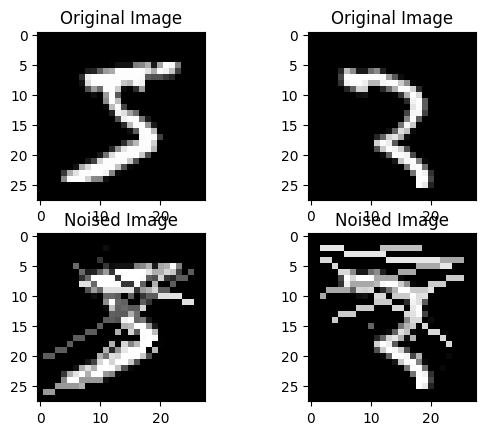

In [11]:
# Немного визуализации

f, axes = plt.subplots(2, 2)

# showing images with gaussian noise
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

# showing images with speckle noise
axes[0, 1].imshow(xtrain[500], cmap='gray')
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[500], cmap="gray")
axes[1, 1].set_title("Noised Image")

In [12]:
# Создаём класс для датасета

class noisedDataset(torch.utils.data.Dataset):

    def __init__(self, datasetnoised, datasetclean, labels, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]
        y = self.labels[idx]

        if self.transform != None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return (xNoise, xClean, y)

In [13]:
# Создаём сеты для DataLoader'а
tsfms = T.Compose([
    T.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [14]:
# Создаём сам DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [15]:
# Используем cuda по возможности
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"

In [16]:
# Берём несколько изображений для проверки на корректность работы 
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [17]:
dirty.shape

torch.Size([32, 784])

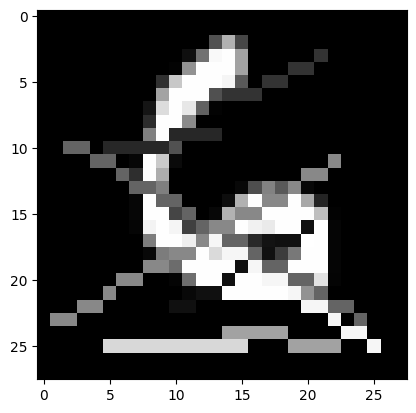

In [18]:
plot(dirty[2])

In [19]:
# Проверка инициализации модели
model = Autoencoder(28 * 28, 32)

# Берём один батч
X, y = dirty, clean

# Применяем модель
Y = model(X)
X.shape, Y.shape

(torch.Size([32, 784]), torch.Size([32, 784]))

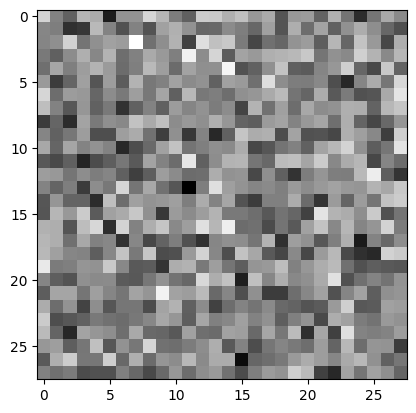

In [20]:
plot(Y[2])

## Задаём функции потерь

In [21]:
def diagram(image):
    # Получаем размер изображения
    h = int(np.sqrt(image.shape[0]))
    image_sq = image.reshape((h, h))

    # Создаём кубический комплекс
    cmplx = gd.CubicalComplex(dimensions=(h, h), top_dimensional_cells=image)

    # Получаем персистентные пары для кубической фильтрации
    cmplx.compute_persistence()
    critical_pairs = cmplx.cofaces_of_persistence_pairs()

    # Получаем номер пикселя в исходном изображении
    bpx0_essential = critical_pairs[1][0][0] // h, critical_pairs[1][0][0] % h

    # Получаем критические пиксели, соответствующие персистентным парам
    try:
        bpx0 = [[critical_pairs[0][0][i][0] // h, critical_pairs[0][0][i][0] % h] for i in
                range(len(critical_pairs[0][0]))]
        dpx0 = [[critical_pairs[0][0][i][1] // h, critical_pairs[0][0][i][1] % h] for i in
                range(len(critical_pairs[0][0]))]
    except IndexError:
        bpx0 = [[]]
        dpx0 = [[]]

    try:
        bpx1 = [[critical_pairs[0][1][i][0] // h, critical_pairs[0][1][i][0] % h] for i in
                range(len(critical_pairs[0][1]))]
        dpx1 = [[critical_pairs[0][1][i][1] // h, critical_pairs[0][1][i][1] % h] for i in
                range(len(critical_pairs[0][1]))]
    except IndexError:
        bpx1 = [[]]
        dpx1 = [[]]

    idx0, idx1 = np.stack([bpx0, dpx0]).T, np.stack([bpx1, dpx1]).T

    # Добавляем нулевой гомологический класс
    pd0_essential = torch.tensor([[image_sq[bpx0_essential], torch.max(image)]])

    # получаем диаграмму устойчивости через индексацию
    if (len(idx0) != 0):
        pd0 = image_sq[idx0]
        pd0 = torch.vstack([pd0, pd0_essential])
    else:
        pd0 = pd0_essential

    if (len(idx1) != 0):
        pd1 = image_sq[idx1]
    else:
        pd1 = torch.zeros((1, 2))

    return pd0, pd1

In [22]:
# Функция для сравнения диаграмм устойчивости
def compare(image1, image2):
    first_pd0, first_pd1 = diagram(image1)
    second_pd0, second_pd1 = diagram(image2)

    return wasserstein_distance(first_pd0, second_pd0, enable_autodiff=True) + \
        wasserstein_distance(first_pd1, second_pd1, enable_autodiff=True)


# Функция топологических потерь
def topo_loss(output, target):
    loss = torch.tensor(0.)
    for i in range(len(output)):
        loss += compare(output[i], target[i])
    return (loss / len(output))

In [23]:
# Проверка работы функции
X_pd0, X_pd1 = diagram(X[7])
Y_pd0, Y_pd1 = diagram(Y[7])
#X_pd0, Y_pd0

In [24]:
# Проверка подсчёта расстояния между диаграммами
wasserstein_distance(X_pd0, Y_pd0, enable_autodiff=True)

/opt/conda/lib/python3.10/site-packages/gudhi/wasserstein/wasserstein.py:282: UserWarning: enable_autodiff=True and keep_essential_parts=True are incompatible together.
                      keep_essential_parts is set to False: only points with finite coordinates are considered
                      in the following.
                      
  warnings.warn('''enable_autodiff=True and keep_essential_parts=True are incompatible together.


tensor(311.0061, grad_fn=<SumBackward0>)

## Checking

Проверка работоспособности функции и вычисления градиента

In [25]:
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [26]:
loss = topo_loss(dirty, clean)

In [27]:
loss.item()

2166.493408203125

In [28]:
loss.backward()

In [29]:
dirty.grad

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0156]])

## Train process

Обучение

In [30]:
%%time
batch_size = batch_size_value

history = np.zeros((n_repeats, n_epochs, 2))

mse_loss_fn = nn.MSELoss()
topo_loss_fn = topo_loss

for repeat_idx in range(n_repeats):

    # Инициализация DataLoader'а
    dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Инициализация модели
    model = Autoencoder(28 * 28, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("{:3} {:6} {:6}".format(repeat_idx + 1, "MSE", "Topo"))

    for epoch_idx in range(n_epochs):

        # Обучение
        model.train()

        mse_loss_epoch = []
        topo_loss_epoch = []

        for X, y, label in tqdm(dataloader_train):
            X = X.view(X.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            y = y.view(y.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            mse_loss_batch = mse_loss_fn(model(X), y)
            topo_loss_batch = topo_loss_fn(model(X), y)
            loss_batch = mse_loss_batch + beta * topo_loss_batch

            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

            mse_loss_epoch.append(mse_loss_batch.detach())
            topo_loss_epoch.append(topo_loss_batch.detach())

        mse_loss_mean = np.mean(mse_loss_epoch)
        topo_loss_mean = np.mean(topo_loss_epoch)

        history[repeat_idx, epoch_idx, 0] = mse_loss_mean
        history[repeat_idx, epoch_idx, 1] = topo_loss_mean

        print("{:3} {:.4f} {:.4f}".format(epoch_idx, mse_loss_mean, topo_loss_mean))
    torch.save(model.state_dict(), f"custom_model_{repeat_idx + 1}.pt")
    print("\r")

  1 MSE    Topo  


100%|██████████| 157/157 [02:36<00:00,  1.00it/s]


  0 4365.9380 2134.9548


100%|██████████| 157/157 [02:36<00:00,  1.00it/s]


  1 3133.7039 2060.3420


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


  2 2769.4834 2043.2289


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


  3 2604.5032 2040.7708


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


  4 2494.3953 2029.2502


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


  5 2436.2905 2024.1045


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


  6 2395.3086 2019.3304


100%|██████████| 157/157 [02:33<00:00,  1.03it/s]


  7 2363.8845 2016.1575


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


  8 2344.0339 2009.5466


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


  9 2330.9695 2008.1495


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 10 2320.0920 2003.1571


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


 11 2312.5532 2001.4431


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 12 2303.7937 1999.7213


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 13 2296.5857 1997.7181


100%|██████████| 157/157 [02:30<00:00,  1.04it/s]


 14 2291.3486 1997.0083


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 15 2286.9045 1996.5514


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 16 2284.5630 1995.8472


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 17 2280.5217 1993.8595


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


 18 2276.6421 1993.5161


100%|██████████| 157/157 [02:35<00:00,  1.01it/s]


 19 2273.2009 1992.9016


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


 20 2272.1743 1990.5474


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


 21 2270.4316 1991.5978


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 22 2266.6331 1990.1278


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


 23 2267.9402 1990.9729


100%|██████████| 157/157 [02:31<00:00,  1.03it/s]


 24 2262.5466 1988.1923


100%|██████████| 157/157 [02:31<00:00,  1.03it/s]


 25 2260.4209 1988.3706


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 26 2258.0945 1986.8214


100%|██████████| 157/157 [02:31<00:00,  1.03it/s]


 27 2257.3630 1987.2854


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


 28 2254.7661 1987.8409


100%|██████████| 157/157 [02:35<00:00,  1.01it/s]


 29 2253.9622 1987.4359


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 30 2251.2246 1986.2253


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 31 2248.8076 1985.9763


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 32 2248.1174 1984.6641


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 33 2246.5261 1982.9470


100%|██████████| 157/157 [02:29<00:00,  1.05it/s]


 34 2243.6338 1982.9674


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


 35 2243.7727 1983.2946


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 36 2241.3745 1981.9261


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 37 2240.4753 1982.4656


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 38 2240.3130 1982.9574


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 39 2238.6299 1981.9634


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 40 2236.5884 1981.0183


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 41 2237.0681 1979.6495


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 42 2235.8403 1979.2056


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


 43 2236.2102 1980.8004


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 44 2235.0933 1979.5111


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 45 2233.6641 1979.0768


100%|██████████| 157/157 [02:30<00:00,  1.04it/s]


 46 2232.7520 1980.5391


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 47 2232.2444 1977.2146


100%|██████████| 157/157 [02:30<00:00,  1.04it/s]


 48 2232.0889 1977.3011


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 49 2229.6445 1977.5531

  2 MSE    Topo  


100%|██████████| 157/157 [02:36<00:00,  1.01it/s]


  0 4399.2524 2138.2827


100%|██████████| 157/157 [02:34<00:00,  1.01it/s]


  1 3150.7620 2060.9004


100%|██████████| 157/157 [02:36<00:00,  1.00it/s]


  2 2807.2727 2046.9204


100%|██████████| 157/157 [02:36<00:00,  1.00it/s]


  3 2624.3135 2038.0590


100%|██████████| 157/157 [02:36<00:00,  1.00it/s]


  4 2521.5349 2028.2677


100%|██████████| 157/157 [02:36<00:00,  1.00it/s]


  5 2448.8113 2018.3364


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


  6 2403.0020 2012.1377


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


  7 2368.9746 2010.3036


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


  8 2341.5891 2004.0579


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


  9 2327.9390 2001.9069


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


 10 2314.1338 1999.4216


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


 11 2306.7151 1995.9082


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


 12 2299.6902 1995.1863


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


 13 2290.6914 1994.2108


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]


 14 2283.3408 1994.6095


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 15 2277.8511 1990.3706


100%|██████████| 157/157 [02:33<00:00,  1.02it/s]


 16 2273.5979 1988.3785


100%|██████████| 157/157 [02:34<00:00,  1.01it/s]


 17 2270.4128 1989.8463


100%|██████████| 157/157 [02:35<00:00,  1.01it/s]


 18 2264.6326 1988.6660


100%|██████████| 157/157 [02:35<00:00,  1.01it/s]


 19 2260.5471 1986.7424


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


 20 2257.3989 1986.6393


100%|██████████| 157/157 [02:36<00:00,  1.00it/s]


 21 2255.2634 1987.1202


100%|██████████| 157/157 [02:35<00:00,  1.01it/s]


 22 2251.9160 1985.8049


100%|██████████| 157/157 [02:36<00:00,  1.00it/s]


 23 2250.9954 1985.6278


100%|██████████| 157/157 [02:38<00:00,  1.01s/it]


 24 2248.6008 1986.0701


100%|██████████| 157/157 [02:40<00:00,  1.03s/it]


 25 2244.3403 1982.4738


100%|██████████| 157/157 [02:39<00:00,  1.02s/it]


 26 2244.1338 1983.4319


100%|██████████| 157/157 [02:39<00:00,  1.01s/it]


 27 2241.2988 1981.3284


100%|██████████| 157/157 [02:38<00:00,  1.01s/it]


 28 2239.2019 1980.5154


100%|██████████| 157/157 [02:41<00:00,  1.03s/it]


 29 2237.0974 1980.0900


100%|██████████| 157/157 [02:40<00:00,  1.02s/it]


 30 2237.1030 1980.1771


100%|██████████| 157/157 [02:41<00:00,  1.03s/it]


 31 2235.2937 1981.4738


100%|██████████| 157/157 [02:39<00:00,  1.02s/it]


 32 2236.1621 1980.7412


100%|██████████| 157/157 [02:40<00:00,  1.02s/it]


 33 2235.0378 1979.9510


100%|██████████| 157/157 [02:40<00:00,  1.02s/it]


 34 2232.7170 1978.9230


100%|██████████| 157/157 [02:39<00:00,  1.02s/it]


 35 2232.7402 1976.1333


100%|██████████| 157/157 [02:41<00:00,  1.03s/it]


 36 2229.1882 1976.4180


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


 37 2231.3745 1978.8595


100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


 38 2229.4021 1977.3746


100%|██████████| 157/157 [02:40<00:00,  1.02s/it]


 39 2229.8325 1976.1560


100%|██████████| 157/157 [02:43<00:00,  1.04s/it]


 40 2229.7424 1976.0773


100%|██████████| 157/157 [02:41<00:00,  1.03s/it]


 41 2227.9834 1976.4489


100%|██████████| 157/157 [02:44<00:00,  1.05s/it]


 42 2228.0291 1976.0972


100%|██████████| 157/157 [02:43<00:00,  1.04s/it]


 43 2226.5378 1975.7567


100%|██████████| 157/157 [02:42<00:00,  1.04s/it]


 44 2226.0317 1974.4363


100%|██████████| 157/157 [02:41<00:00,  1.03s/it]


 45 2225.6755 1974.2942


100%|██████████| 157/157 [02:39<00:00,  1.02s/it]


 46 2225.9690 1975.5396


100%|██████████| 157/157 [02:36<00:00,  1.00it/s]


 47 2222.6465 1972.5597


100%|██████████| 157/157 [02:36<00:00,  1.01it/s]


 48 2223.1074 1972.2074


100%|██████████| 157/157 [02:38<00:00,  1.01s/it]


 49 2222.5317 1972.1259

  3 MSE    Topo  


100%|██████████| 157/157 [02:44<00:00,  1.05s/it]


  0 4444.5527 2128.0171


100%|██████████| 157/157 [02:47<00:00,  1.07s/it]


  1 3173.4348 2062.7510


100%|██████████| 157/157 [02:48<00:00,  1.07s/it]


  2 2781.9094 2046.7540


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


  3 2617.6125 2044.0515


100%|██████████| 157/157 [02:45<00:00,  1.05s/it]


  4 2524.2058 2036.2856


100%|██████████| 157/157 [02:39<00:00,  1.02s/it]


  5 2460.6167 2030.7595


100%|██████████| 157/157 [02:39<00:00,  1.02s/it]


  6 2410.7031 2026.6102


100%|██████████| 157/157 [02:39<00:00,  1.02s/it]


  7 2370.4861 2022.5852


100%|██████████| 157/157 [02:38<00:00,  1.01s/it]


  8 2342.4546 2015.9640


100%|██████████| 157/157 [02:38<00:00,  1.01s/it]


  9 2325.2642 2013.4341


100%|██████████| 157/157 [02:40<00:00,  1.02s/it]


 10 2315.2437 2008.7260


100%|██████████| 157/157 [02:38<00:00,  1.01s/it]


 11 2302.8679 2006.0784


100%|██████████| 157/157 [02:38<00:00,  1.01s/it]


 12 2296.7285 2005.3969


100%|██████████| 157/157 [02:39<00:00,  1.01s/it]


 13 2291.2991 2003.1708


100%|██████████| 157/157 [02:37<00:00,  1.00s/it]


 14 2286.5176 2002.6210


100%|██████████| 157/157 [02:37<00:00,  1.00s/it]


 15 2280.2874 2002.0287


100%|██████████| 157/157 [02:38<00:00,  1.01s/it]


 16 2276.7527 2000.6736


100%|██████████| 157/157 [02:37<00:00,  1.00s/it]


 17 2272.8054 1998.6411


100%|██████████| 157/157 [02:35<00:00,  1.01it/s]


 18 2268.2947 1998.5912


100%|██████████| 157/157 [02:36<00:00,  1.00it/s]


 19 2264.0383 1997.1802


100%|██████████| 157/157 [02:35<00:00,  1.01it/s]


 20 2261.4924 1997.1809


100%|██████████| 157/157 [02:36<00:00,  1.00it/s]


 21 2259.0847 1997.1393


100%|██████████| 157/157 [02:36<00:00,  1.00it/s]


 22 2255.8386 1996.9606


100%|██████████| 157/157 [02:36<00:00,  1.00it/s]


 23 2253.0146 1995.0732


100%|██████████| 157/157 [02:26<00:00,  1.07it/s]


 24 2251.7322 1995.6481


100%|██████████| 157/157 [02:22<00:00,  1.11it/s]


 25 2249.6030 1995.1859


100%|██████████| 157/157 [02:24<00:00,  1.09it/s]


 26 2248.4026 1994.5864


100%|██████████| 157/157 [02:28<00:00,  1.06it/s]


 27 2244.5156 1994.2250


100%|██████████| 157/157 [02:26<00:00,  1.07it/s]


 28 2241.3755 1993.3025


100%|██████████| 157/157 [02:23<00:00,  1.10it/s]


 29 2238.9343 1992.1683


100%|██████████| 157/157 [02:24<00:00,  1.09it/s]


 30 2236.5554 1992.3516


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


 31 2234.4136 1992.2333


100%|██████████| 157/157 [02:42<00:00,  1.04s/it]


 32 2232.6589 1992.2598


100%|██████████| 157/157 [02:39<00:00,  1.02s/it]


 33 2231.9729 1992.1613


100%|██████████| 157/157 [02:37<00:00,  1.00s/it]


 34 2230.8701 1989.8043


100%|██████████| 157/157 [02:42<00:00,  1.04s/it]


 35 2228.3367 1989.6083


100%|██████████| 157/157 [02:41<00:00,  1.03s/it]


 36 2226.8843 1990.0221


100%|██████████| 157/157 [02:42<00:00,  1.03s/it]


 37 2226.5071 1990.2844


100%|██████████| 157/157 [02:38<00:00,  1.01s/it]


 38 2225.6997 1989.7271


100%|██████████| 157/157 [02:48<00:00,  1.07s/it]


 39 2225.5859 1987.8801


100%|██████████| 157/157 [02:47<00:00,  1.07s/it]


 40 2223.7778 1989.1252


100%|██████████| 157/157 [02:39<00:00,  1.01s/it]


 41 2222.7278 1987.7067


100%|██████████| 157/157 [02:45<00:00,  1.06s/it]


 42 2221.4595 1987.2500


100%|██████████| 157/157 [02:38<00:00,  1.01s/it]


 43 2220.7849 1985.8112


100%|██████████| 157/157 [02:32<00:00,  1.03it/s]


 44 2218.9026 1984.8623


100%|██████████| 157/157 [02:37<00:00,  1.00s/it]


 45 2220.0688 1985.7567


100%|██████████| 157/157 [02:37<00:00,  1.00s/it]


 46 2219.2117 1986.2563


100%|██████████| 157/157 [02:35<00:00,  1.01it/s]


 47 2219.1147 1987.6986


100%|██████████| 157/157 [02:34<00:00,  1.02it/s]


 48 2217.8328 1986.5354


100%|██████████| 157/157 [02:31<00:00,  1.04it/s]

 49 2215.8455 1984.4258

CPU times: user 12h 49min 45s, sys: 43.1 s, total: 12h 50min 28s
Wall time: 6h 30min 6s


In [31]:
x = np.arange(n_epochs)
mse_ci1 = history.mean(axis=0)[:, 0] - history.std(axis=0)[:, 0]
mse_ci2 = history.mean(axis=0)[:, 0] + history.std(axis=0)[:, 0]
topo_ci1 = history.mean(axis=0)[:, 1] - history.std(axis=0)[:, 1]
topo_ci2 = history.mean(axis=0)[:, 1] + history.std(axis=0)[:, 1]

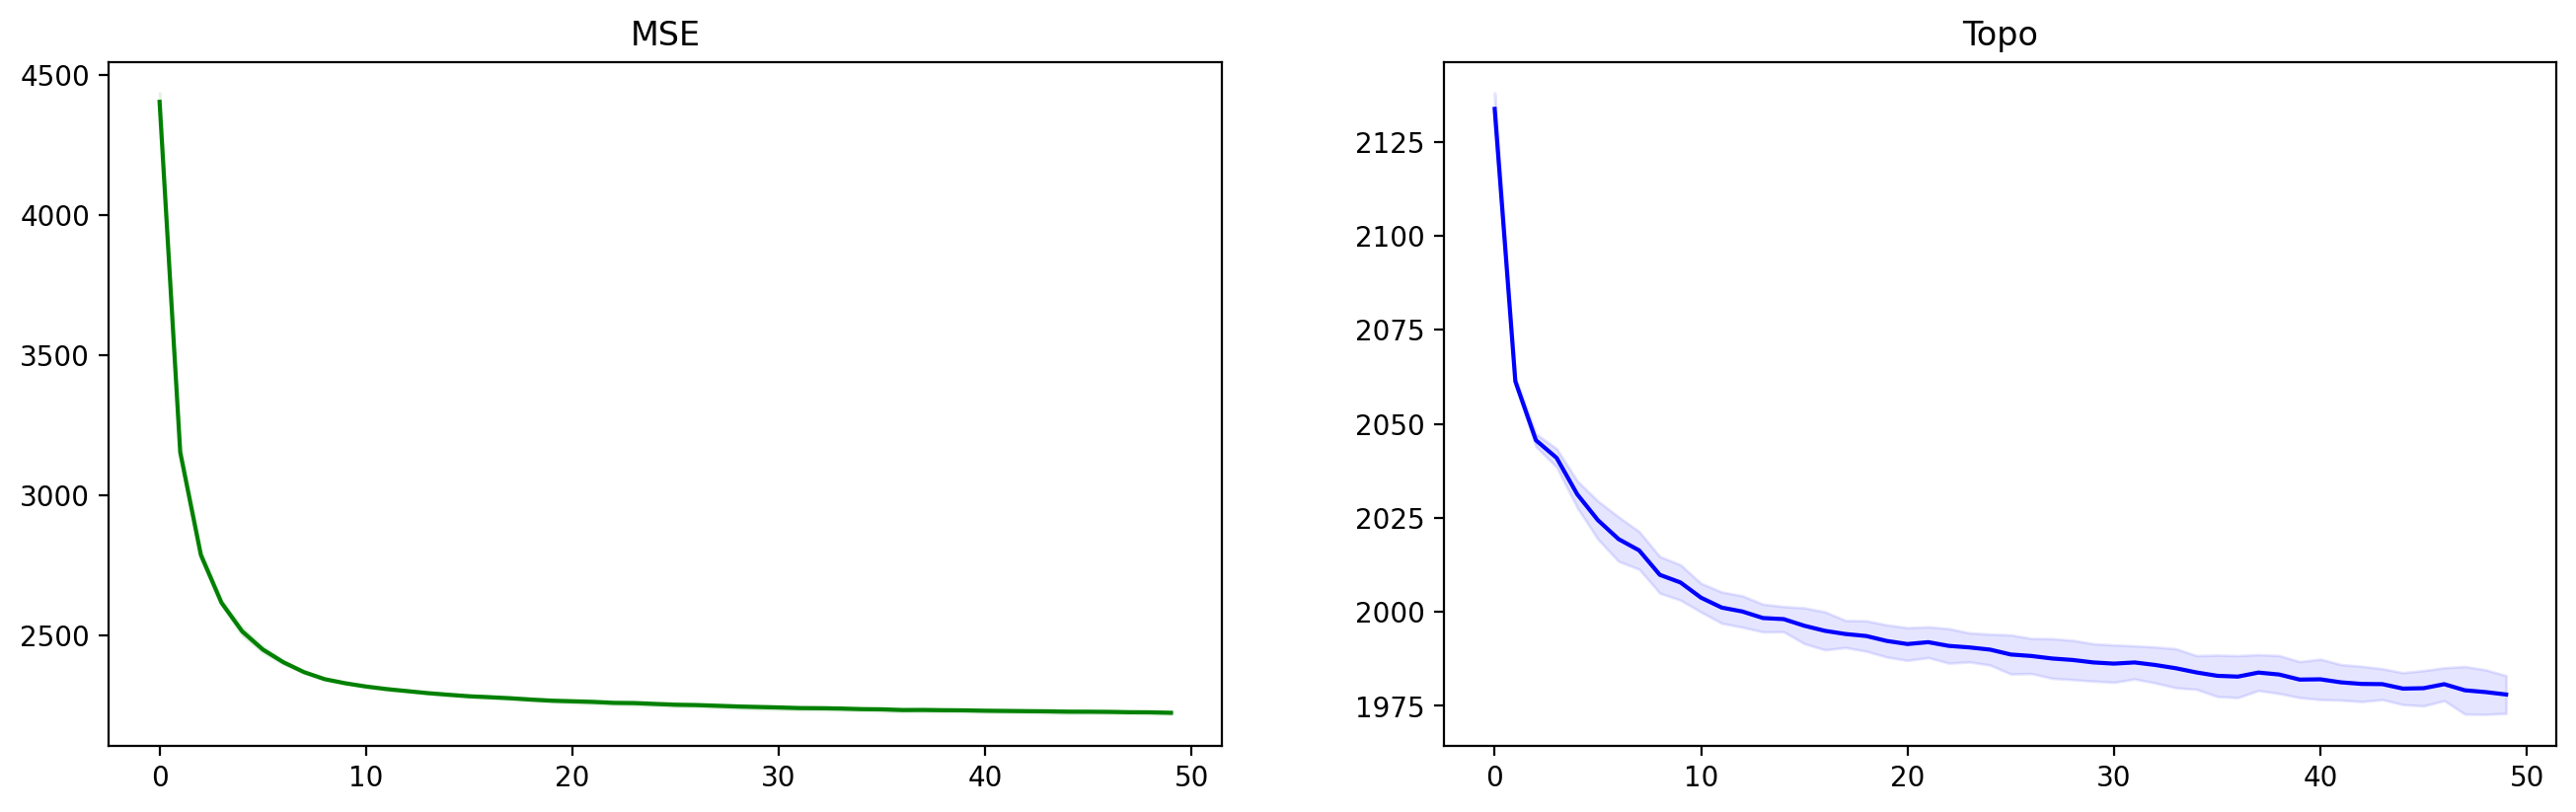

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
ax[0].set_title("MSE")
ax[1].set_title("Topo")
ax[0].plot(history.mean(axis=0)[:, 0], c="g", label="MSE")
ax[0].fill_between(x, mse_ci1, mse_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:, 1], c="b", label="Topo")
ax[1].fill_between(x, topo_ci1, topo_ci2, color="b", alpha=0.1)
plt.show()

In [33]:
def plot_dgm(img, ax):
    cmplx = gd.CubicalComplex(dimensions=img.shape, top_dimensional_cells=img.flatten())
    diag = cmplx.persistence()
    gd.plot_persistence_diagram(diag, legend=True, axes=ax)

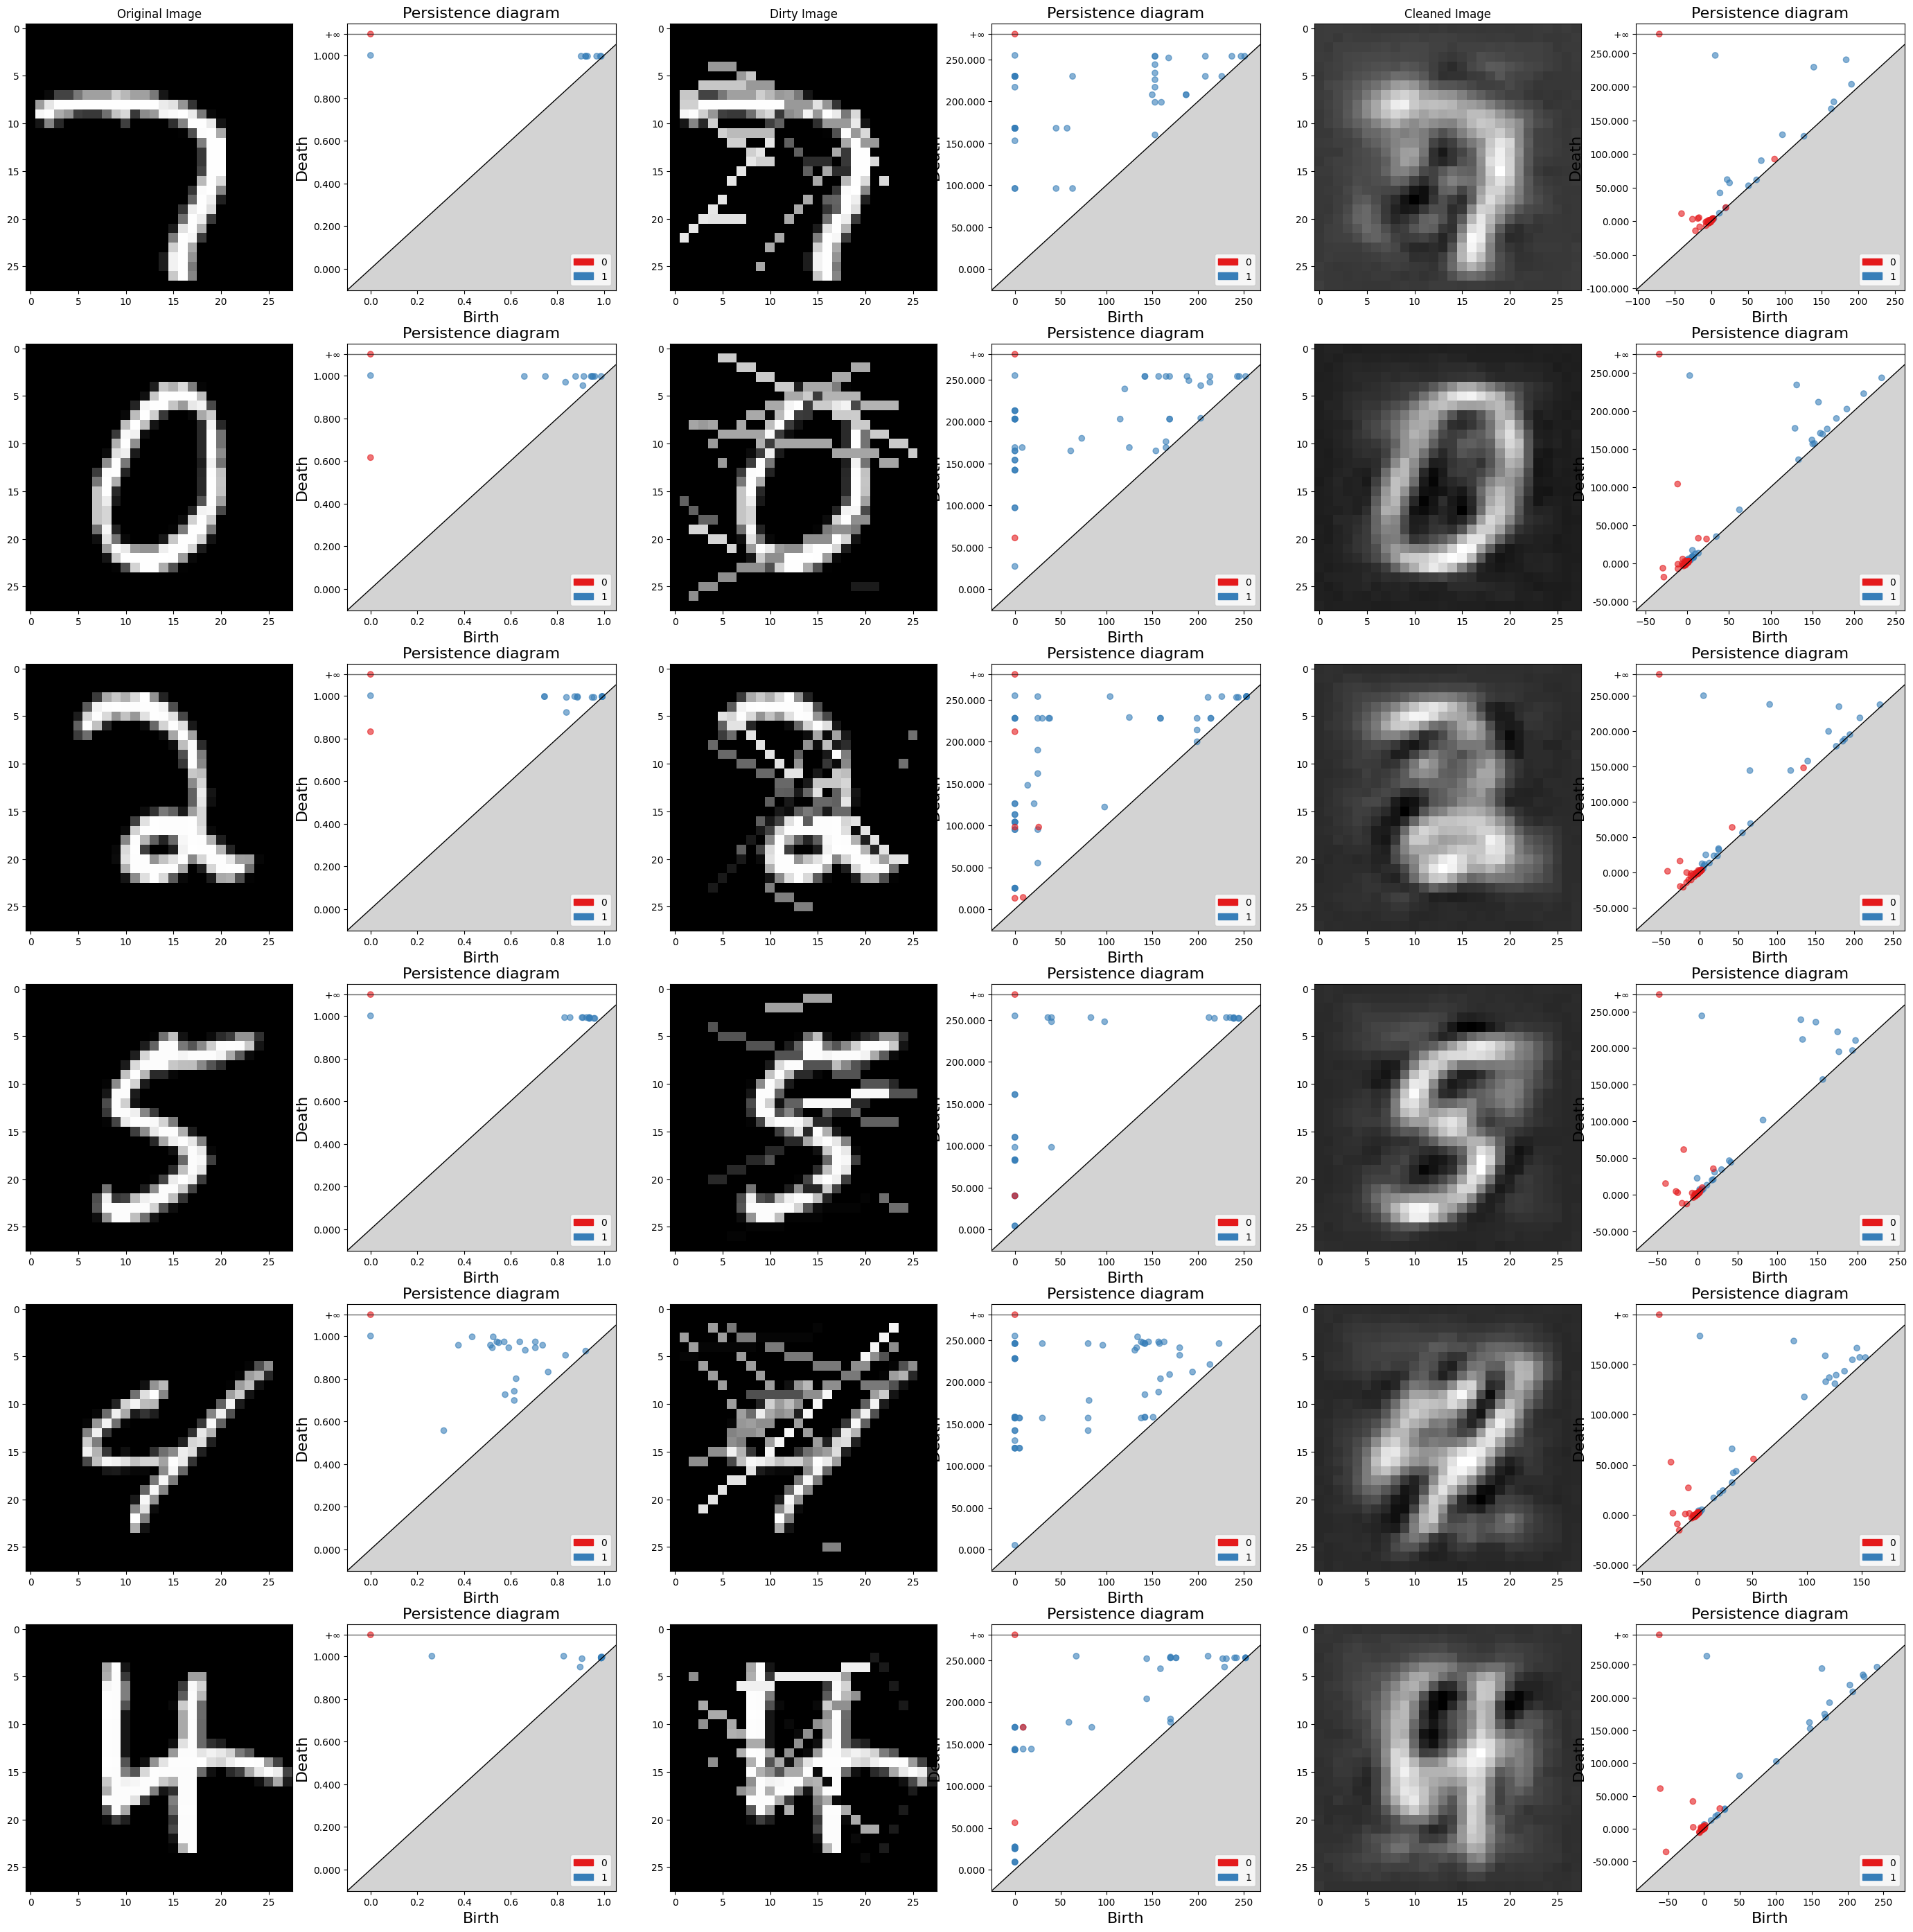

In [34]:
# Результаты работы модели на 6-и случайных примерах

f, axes = plt.subplots(6, 6, figsize=(35, 35))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Original diagram")
axes[0, 2].set_title("Dirty Image")
axes[0, 3].set_title("Dirty diagram")
axes[0, 4].set_title("Cleaned Image")
axes[0, 5].set_title("Cleaned diagram")

test_imgs = np.random.randint(0, 500, size=6)
for idx in range((6)):
    dirty = testset[test_imgs[idx]][0]
    clean = testset[test_imgs[idx]][1]
    label = testset[test_imgs[idx]][2]
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)

    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()

    dirty = dirty.view(1, 28, 28)
    dirty = dirty.permute(1, 2, 0).squeeze(2)
    dirty = dirty.detach().cpu().numpy()

    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()

    axes[idx, 0].imshow(clean, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][1], axes[idx, 1])

    axes[idx, 2].imshow(dirty, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][0], axes[idx, 3])
    axes[idx, 4].imshow(output, cmap="gray")
    plot_dgm(output, axes[idx, 5])

In [35]:
# Выводим историю loss'ов (на всякий случай)
print(history)

[[[4365.93798828 2134.95483398]
  [3133.70385742 2060.34204102]
  [2769.48339844 2043.22888184]
  [2604.50317383 2040.77075195]
  [2494.39526367 2029.25024414]
  [2436.29052734 2024.10449219]
  [2395.30859375 2019.33044434]
  [2363.88452148 2016.1574707 ]
  [2344.03393555 2009.54663086]
  [2330.96948242 2008.14953613]
  [2320.09204102 2003.15710449]
  [2312.55322266 2001.44311523]
  [2303.79370117 1999.72131348]
  [2296.58569336 1997.71813965]
  [2291.34863281 1997.00830078]
  [2286.90454102 1996.5513916 ]
  [2284.56298828 1995.84716797]
  [2280.52172852 1993.85949707]
  [2276.64208984 1993.51611328]
  [2273.20092773 1992.90161133]
  [2272.17431641 1990.54736328]
  [2270.43164062 1991.59777832]
  [2266.63305664 1990.12780762]
  [2267.94018555 1990.97290039]
  [2262.54663086 1988.19226074]
  [2260.42089844 1988.37060547]
  [2258.09448242 1986.82141113]
  [2257.36303711 1987.28540039]
  [2254.76611328 1987.84094238]
  [2253.9621582  1987.43591309]
  [2251.22460938 1986.2253418 ]
  [2248.